# Topic Classification News

## Prepare Train Dataset

In [4]:
# install kora (untuk akses google drive)
!pip install kora -q
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 23.1 MB/s eta 0:00:00


In [32]:
# import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, log_loss

In [7]:
# Download model dan dataset dari folder di Google Drive kami
from kora import drive
from urllib.request import urlretrieve
import sys

def download_folder(folder_id):
    # authenticate
    from google.colab import auth
    auth.authenticate_user()
    # get folder_name
    from googleapiclient.discovery import build
    service = build('drive', 'v3')
    folder_name = service.files().get(fileId=folder_id).execute()['name']
    # install library
    url = 'https://github.com/segnolin/google-drive-folder-downloader/raw/master/download.py'
    path = 'download.py'
    urlretrieve(url, path)
    # recursive download
    import download
    download.download_folder(service, folder_id, './', folder_name)
    return folder_name

folder_name = download_folder('1qtTMSILj76-15k7OZij5mabZin3kZ4p6')  # id folder penyimpanan dataset dan model
sys.path.insert(0, f"/content/{folder_name}")

1I8BNWqOG1ba8ddEEf3ArGZ3i8o9m4wvB labelled_newscatcher_dataset.csv text/csv (1/1)
Download 100%.


In [8]:
# Load and tampilkan sebagian data
dataset_article = pd.read_csv(f'./{folder_name}/labelled_newscatcher_dataset.csv', sep=";")

dataset_article

,topic,link,domain,published_date,title,lang
0,SCIENCE,https://www.eurekalert.org/pub_releases/2020-0...,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...,en
1,SCIENCE,https://www.pulse.ng/news/world/an-irresistibl...,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu...",en
2,SCIENCE,https://www.express.co.uk/news/science/1322607...,express.co.uk,2020-08-13 21:01:00,Artificial intelligence warning: AI will know ...,en
3,SCIENCE,https://www.ndtv.com/world-news/glaciers-could...,ndtv.com,2020-08-03 22:18:26,Glaciers Could Have Sculpted Mars Valleys: Study,en
4,SCIENCE,https://www.thesun.ie/tech/5742187/perseid-met...,thesun.ie,2020-08-12 19:54:36,Perseid meteor shower 2020: What time and how ...,en
...,...,...,...,...,...,...
108769,NATION,https://www.vanguardngr.com/2020/08/pdp-govern...,vanguardngr.com,2020-08-08 02:40:00,PDP governors’ forum urges security agencies t...,en
108770,BUSINESS,https://www.patentlyapple.com/patently-apple/2...,patentlyapple.com,2020-08-08 01:27:12,"In Q2-20, Apple Dominated the Premium Smartpho...",en
108771,HEALTH,https://www.belfastlive.co.uk/news/health/coro...,belfastlive.co.uk,2020-08-12 17:01:00,Coronavirus Northern Ireland: Full breakdown s...,en
108772,ENTERTAINMENT,https://www.thenews.com.pk/latest/696364-paul-...,thenews.com.pk,2020-08-05 04:59:00,Paul McCartney details post-Beatles distress a...,en


In [9]:
dataset_article['topic'].value_counts()

TECHNOLOGY       15000
HEALTH           15000
WORLD            15000
ENTERTAINMENT    15000
SPORTS           15000
BUSINESS         15000
NATION           15000
SCIENCE           3774
Name: topic, dtype: int64

In [10]:
dataset_article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108774 entries, 0 to 108773
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   topic           108774 non-null  object
 1   link            108774 non-null  object
 2   domain          108774 non-null  object
 3   published_date  108774 non-null  object
 4   title           108774 non-null  object
 5   lang            108774 non-null  object
dtypes: object(6)
memory usage: 5.0+ MB


In [11]:
date_range = dataset_article['published_date'].min(), dataset_article['published_date'].max()
date_range

('2012-09-16 04:44:50', '2020-08-18 05:49:00')

In [12]:
# sample hanya beberapa data, karena keterbatasan resource yang digunakan
from sklearn.model_selection import train_test_split

# Melakukan stratified sampling pada kolom 'kategori'
dataset, _ = train_test_split(dataset_article, train_size=10000, stratify=dataset_article['topic'], random_state=42)
dataset

,topic,link,domain,published_date,title,lang
28130,BUSINESS,https://www.globenewswire.com/news-release/202...,globenewswire.com,2020-08-04 12:13:00,Insights on the Remote Sensing Services Global...,en
47192,WORLD,https://www.thestar.com.my/news/world/2020/08/...,thestar.com.my,2020-08-05 05:32:00,"Modi, Muslims to attend temple ceremony on con...",en
48704,ENTERTAINMENT,http://theindependent.sg/miley-cyrus-reveals-t...,theindependent.sg,2020-08-16 10:00:00,Miley Cyrus reveals that she lost her virginit...,en
93754,HEALTH,https://ca.sports.yahoo.com/news/major-coronav...,ca.sports.yahoo.com,2020-08-07 14:00:00,Coronavirus: The 16 major developments that ha...,en
29888,WORLD,https://news.yahoo.com/sacramento-selected-cov...,news.yahoo.com,2020-08-13 04:21:13,Sacramento selected as COVID-19 vaccine trial ...,en
...,...,...,...,...,...,...
78065,WORLD,https://globalnews.ca/news/7262248/coronavirus...,globalnews.ca,2020-08-10 11:20:32,'$100 billion will be needed': Huge gap in vac...,en
3685,HEALTH,https://www.midlands103.com/news/midlands-news...,midlands103.com,2020-08-04 14:38:41,Laois Man Battling Skin Cancer Urges More Peop...,en
94216,BUSINESS,https://www.globenewswire.com/news-release/202...,globenewswire.com,2020-08-12 05:30:00,Nicox Partners ZERVIATE in the Gulf and Arab M...,en
15306,WORLD,https://globalnews.ca/news/7255253/coronavirus...,globalnews.ca,2020-08-06 18:31:33,Coronavirus: CDC lifts travel warnings for 20 ...,en


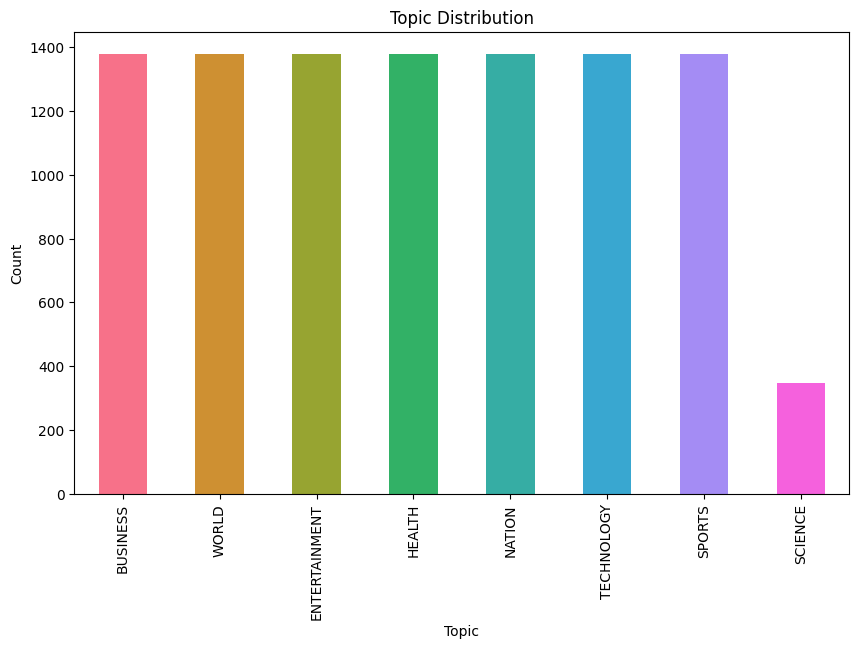

In [13]:
# plot topic distribution
topic_counts = dataset['topic'].value_counts()
colors = sns.color_palette('husl', len(topic_counts))
# Plotting
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar', color=colors)
plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()

In [14]:
# drop unused field
columns_to_drop = ['link', 'domain', 'published_date', 'lang']
dataset = dataset.drop(columns=columns_to_drop)
dataset

,topic,title
28130,BUSINESS,Insights on the Remote Sensing Services Global...
47192,WORLD,"Modi, Muslims to attend temple ceremony on con..."
48704,ENTERTAINMENT,Miley Cyrus reveals that she lost her virginit...
93754,HEALTH,Coronavirus: The 16 major developments that ha...
29888,WORLD,Sacramento selected as COVID-19 vaccine trial ...
...,...,...
78065,WORLD,'$100 billion will be needed': Huge gap in vac...
3685,HEALTH,Laois Man Battling Skin Cancer Urges More Peop...
94216,BUSINESS,Nicox Partners ZERVIATE in the Gulf and Arab M...
15306,WORLD,Coronavirus: CDC lifts travel warnings for 20 ...


In [15]:
label = dataset['topic'].unique()
label

array(['BUSINESS', 'WORLD', 'ENTERTAINMENT', 'HEALTH', 'NATION',
       'TECHNOLOGY', 'SPORTS', 'SCIENCE'], dtype=object)

In [16]:
# mapping label
label_mapping = {
    'SCIENCE': 0,
    'TECHNOLOGY': 1,
    'HEALTH': 2,
    'WORLD': 3,
    'ENTERTAINMENT': 4,
    'SPORTS': 5,
    'BUSINESS': 6,
    'NATION': 7
}
label_mapping_reverse=['SCIENCE','TECHNOLOGY','HEALTH','WORLD','ENTERTAINMENT','SPORTS','BUSINESS','NATION']

#### Create Dataset Dict

In [20]:
X_dict = dataset['title'].tolist()
y_dict = dataset['topic']
y_dict = y_dict.replace(label_mapping).tolist()

# Split the dataset into train (80%), test (10%), and validation (10%)
X_train_dict, X_test_val_dict, y_train_dict, y_test_val_dict = train_test_split(X_dict , y_dict, test_size =0.2, random_state =42)
X_test_dict, X_val_dict, y_test_dict, y_val_dict = train_test_split(X_test_val_dict , y_test_val_dict, test_size =0.5, random_state =42)

In [21]:
train_data = {'text': X_train_dict, 'label': y_train_dict}
validation_data = {'text': X_val_dict, 'label': y_val_dict}
test_data = {'text': X_test_dict, 'label': y_test_dict}

In [22]:
# Create DatasetDict
from datasets import DatasetDict, Dataset

dataset_dict = DatasetDict({
    'train': Dataset.from_dict(train_data),
    'validation': Dataset.from_dict(validation_data),
    'test': Dataset.from_dict(test_data)
})
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})

## Model Training

### Split dataset Train

In [46]:
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
# Split the dataset into train (80%), test (10%), and validation (10%)
train, test_val= train_test_split(dataset, test_size=0.2, random_state=42)
test, val = train_test_split(test_val, test_size=0.5, random_state=42)

# Display the shapes of the split datasets
print(f"Train set shape: {train.shape}")
print(f"Test set shape: {test.shape}")
print(f"Validation set shape: {val.shape}")

Train set shape: (8000, 2)
Test set shape: (1000, 2)
Validation set shape: (1000, 2)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Model RNN-based

In [48]:
# install depedencies
!pip install tensorflow transformers -q
!pip install datasets -q
!pip install transformers[torch]
!pip install evaluate
!pip install gensim -q

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
# import library dan modul yang akan digunakan
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from datasets import load_dataset


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Pre-process dataset

In [50]:
# split dataset antara text dan label
X_rnn = dataset['title'].tolist()
y_rnn = dataset['topic']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
# melakukan encoding terhadap label
# - 'SCIENCE' = 0
# - 'TECHNOLOGY' = 1
# - 'HEALTH' = 2
# - 'WORLD' = 3
# - 'ENTERTAINMENT' = 4
# - 'SPORTS'= 5
# - 'BUSINESS' = 6
# - 'NATION' = 7


y_rnn = y_rnn.replace(label_mapping).tolist()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
# inisialisasi tokenizer dengan jumlah maksimum kata yang unik sebanyak 10000
max_words = 10000
tokenizer_rnn = Tokenizer(num_words = max_words)

# fit tokenizer dengan teks data untuk menciptakan kamus
tokenizer_rnn.fit_on_texts(X_rnn)

# mengkonversi teks menjadi sequence integer token berdasarkan kamus
sequences = tokenizer_rnn.texts_to_sequences(X_rnn)

# memberikan pading terhadap sequence ke panjang yang ditentukan
X_rnn_out = pad_sequences(sequences, maxlen=100)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
# konversi data menjadi numpy array untuk dapat diproses library / modul yang akan digunakan, serta melakukan one-hot encoding terhadap label karena output berupa multi-class
X_rnn_out = np.array(X_rnn_out)
y_rnn_out = np.eye(8)[np.array(y_rnn)]

# Split the dataset into train (80%), test (10%), and validation (10%)
X_train_rnn, X_test_val_rnn, y_train_rnn, y_test_val_rnn = train_test_split(X_rnn_out , y_rnn_out, test_size =0.2, random_state =42)
X_test_rnn, X_val_rnn, y_test_rnn, y_val_rnn = train_test_split(X_test_val_rnn , y_test_val_rnn, test_size =0.2, random_state =42)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Training

In [54]:
# import library word2vec
from gensim.models import Word2Vec

# melatih model word2vec dengan menggunakan text sebelumnya dengan vektor 300 dimensi dengan window 5 kata sebelum dan 5 kata sesudah target, dengan jumlah minimum kata setidaknya 1 kali
word2vec_model = Word2Vec(sentences = X_rnn, vector_size=300, window=5, min_count=1, sg=0)

# menyimpan model word2vec yang sudah dilatih
word2vec_model.save("word2vec.model")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred

In [55]:
embedding_matrix_word2vec = np.zeros((max_words, 300))
for word, i in tokenizer_rnn.word_index.items():
  if i < max_words:
    if word in word2vec_model.wv:
      embedding_matrix_word2vec[i] = word2vec_model.wv[word]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
# membuat sekuens model untuk memberikan layer secara sekuensial
model_rnn_word2vec = Sequential()

# menambahkan embedding layer dengan menggunakan embedding matrix yang sudah dihasilkan sebelumnya untuk mengkonversi integer token menjadi dense vector
model_rnn_word2vec.add(Embedding(input_dim=max_words, output_dim=300, input_length=X_train_rnn.shape[1], weights=[embedding_matrix_word2vec], trainable=True))

# menambahkan bidirectional LTSM dengan 64 unit dan return sequence untuk input selanjutnya
model_rnn_word2vec.add(Bidirectional(LSTM(64, return_sequences=True)))

# menambahkan bidirectional LTSM dengan 32 unit (final hidden layer)
model_rnn_word2vec.add(Bidirectional(LSTM(32)))

# menambahkan dropout layer
model_rnn_word2vec.add(Dropout(0.2))

# menambahkan dense layer dengan output 3 unit dengan fungsi aktivasi softmax dikarenakan output merupakan multi-class label
model_rnn_word2vec.add(Dense(8, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
# compile model menggunakan binary cross-entropy loss, Adam optimizer dan akurasi metriks
model_rnn_word2vec.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn_word2vec.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          3000000   
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          186880    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 3228616 (12.32 MB)
Trainable params: 32286

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
from tensorflow.keras.callbacks import EarlyStopping
# melakukan train model menggunakan training data(X_train, y_train)
# dengan epoch atau bayaknya training adalah 10
# dengan batch size atau ukuran sampel yang akan digunakan setiap update bobot model adalah 32
# dan validation_data atau data yang digunakan untuk evaluasi model pada validation set selama training adalah (X_test, y_test)
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_rnn = model_rnn_word2vec.fit(X_train_rnn, y_train_rnn, epochs=15, batch_size=100, validation_data=(X_val_rnn, y_val_rnn))

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


80/80 [==============================] - 41s 363ms/step - loss: 0.4152 - accuracy: 0.1404 - val_loss: 0.3712 - val_accuracy: 0.1450
Epoch 2/15
80/80 [==============================] - 12s 149ms/step - loss: 0.3633 - accuracy: 0.2061 - val_loss: 0.3458 - val_accuracy: 0.2750
Epoch 3/15
80/80 [==============================] - 6s 81ms/step - loss: 0.3072 - accuracy: 0.4004 - val_loss: 0.3010 - val_accuracy: 0.4400
Epoch 4/15
80/80 [==============================] - 8s 100ms/step - loss: 0.2433 - accuracy: 0.5753 - val_loss: 0.2753 - val_accuracy: 0.5150
Epoch 5/15
80/80 [==============================] - 4s 55ms/step - loss: 0.1922 - accuracy: 0.7050 - val_loss: 0.2756 - val_accuracy: 0.5375
Epoch 6/15
80/80 [==============================] - 2s 23ms/step - loss: 0.1508 - accuracy: 0.8095 - val_loss: 0.2800 - val_accuracy: 0.5525
Epoch 7/15
80/80 [==============================] - 2s 24ms/step - loss: 0.1138 - accuracy: 0.8825 - val_loss: 0.2822 - val_accuracy: 0.5900
Epoch 8/15
80/80 [=

In [66]:
# save model
# from google.colab import drive
# drive.mount('/gdrive')
# model_rnn_word2vec.save('model/model_rnn_word2vec', save_format="h5")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# from keras.models import load_model
# model_rnn_word2vec_load = load_model('model/model_rnn_word2vec')

In [61]:
# evaluasi model berupa loss dan akurasi pada data train
print("TRAIN")
loss, accuracy = model_rnn_word2vec.evaluate(X_train_rnn, y_train_rnn)
print(f'loss: {loss:.4f}')
print(f'accuracy: {accuracy:.4f}')

y_pred = model_rnn_word2vec.predict(X_train_rnn)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_train_rnn, axis=1)

# Print f1, precision, and recall scores
print(f'precision:{precision_score(y_test, y_pred , average="macro")}')
print(f'recall:{recall_score(y_test, y_pred , average="macro")}')
print(f'f1_score:{f1_score(y_test, y_pred , average="macro")}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TRAIN
250/250 [==============================] - 4s 9ms/step - loss: 0.0171 - accuracy: 0.9870
loss: 0.0171
accuracy: 0.9870
250/250 [==============================] - 3s 7ms/step
precision:0.985560395123897
recall:0.9848238871533642
f1_score:0.9851637660480633


In [62]:
# evaluasi model berupa loss dan akurasi pada data val
print("VALIDATION")
loss, accuracy = model_rnn_word2vec.evaluate(X_val_rnn, y_val_rnn)
print(f'loss: {loss:.4f}')
print(f'accuracy: {accuracy:.4f}')

y_pred =model_rnn_word2vec.predict(X_val_rnn)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_val_rnn, axis=1)
# Print f1, precision, and recall scores
print(f'precision:{precision_score(y_test, y_pred , average="macro")}')
print(f'recall:{recall_score(y_test, y_pred , average="macro")}')
print(f'f1_score:{f1_score(y_test, y_pred , average="macro")}')

VALIDATION
13/13 [==============================] - 0s 9ms/step - loss: 0.3758 - accuracy: 0.5950


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


loss: 0.3758
accuracy: 0.5950
13/13 [==============================] - 1s 12ms/step
precision:0.6228627763728423
recall:0.5985388574357103
f1_score:0.6065443154382344


In [63]:
# evaluasi model berupa loss dan akurasi pada data test
print("TEST")
loss, accuracy =model_rnn_word2vec.evaluate(X_test_rnn, y_test_rnn)
print(f'loss: {loss:.4f}')
print(f'accuracy: {accuracy:.4f}')

y_pred = model_rnn_word2vec.predict(X_test_rnn)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_rnn, axis=1)

# Print f1, precision, and recall scores
print(f'precision:{precision_score(y_test, y_pred , average="macro")}')
print(f'recall:{recall_score(y_test, y_pred , average="macro")}')
print(f'f1_score:{f1_score(y_test, y_pred , average="macro")}')

TEST
11/50 [=====>........................] - ETA: 0s - loss: 0.3312 - accuracy: 0.6534

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


50/50 [==============================] - 1s 10ms/step - loss: 0.3467 - accuracy: 0.6269
loss: 0.3467
accuracy: 0.6269
50/50 [==============================] - 1s 11ms/step
precision:0.6576617180631057
recall:0.617571061015532
f1_score:0.6301562595049629


### Model Attention

In [17]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.0
    Uninstalling huggingface-hub-0.19.0:
      Successfully uninstalled huggingface-hub-0.19.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 2.2 MB/s eta 0:00:00


In [18]:
# import library
import tensorflow as tf
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import load_dataset, DatasetDict

In [23]:
# dataset yang akan digunakan
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})

In [24]:
# tokenize using bert
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)

def tokenize_function(examples):
  return tokenizer_bert(examples['text'], padding="max_length", truncation=True)

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [25]:
# init model with num label 8
model_bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=8)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [27]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer")

trainer = Trainer(
    model =model_bert,
    args =training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['validation'],
    compute_metrics=compute_metrics
)

In [28]:
trainer.train()

Step,Training Loss
500,1.019600
1000,0.809100
1500,0.543900
2000,0.483600
2500,0.288300
3000,0.272400


TrainOutput(global_step=3000, training_loss=0.5694693603515625, metrics={'train_runtime': 2273.9195, 'train_samples_per_second': 10.554, 'train_steps_per_second': 1.319, 'total_flos': 6315005509632000.0, 'train_loss': 0.5694693603515625, 'epoch': 3.0})

In [29]:
result = trainer.evaluate()
result

{'eval_loss': 0.9663482904434204,
 'eval_accuracy': 0.779,
 'eval_runtime': 33.9433,
 'eval_samples_per_second': 29.461,
 'eval_steps_per_second': 3.683,
 'epoch': 3.0}

In [30]:
# melakukan prediksi menggunakan model yang telah dibangun untuk dataset train
result = trainer.predict(tokenized_datasets['train'])

In [33]:
y_pred = np.argmax(result.predictions, axis=1)
y_test = result.label_ids
print('Train Metric')
print(result.metrics)
print(f'accuracy: {accuracy_score(y_test,  y_pred)}')
print(f'precision:{precision_score(y_test, y_pred , average="macro")}')
print(f'recall:{recall_score(y_test, y_pred , average="macro")}')
print(f'f1_score:{f1_score(y_test, y_pred , average="macro")}')

Train Metric
{'test_loss': 0.15645505487918854, 'test_accuracy': 0.961, 'test_runtime': 267.8199, 'test_samples_per_second': 29.871, 'test_steps_per_second': 3.734}
accuracy: 0.961
precision:0.961288537045141
recall:0.9586107021519932
f1_score:0.959835285999082


In [34]:
# melakukan prediksi menggunakan model yang telah dibangun untuk dataset test
result = trainer.predict(tokenized_datasets['validation'])

In [35]:
y_pred = np.argmax(result.predictions, axis=1)
y_test = result.label_ids
print('Validation Metric')
print(result.metrics)
print(f'accuracy: {accuracy_score(y_test,  y_pred)}')
print(f'precision:{precision_score(y_test, y_pred , average="macro")}')
print(f'recall:{recall_score(y_test, y_pred , average="macro")}')
print(f'f1_score:{f1_score(y_test, y_pred , average="macro")}')

Validation Metric
{'test_loss': 0.9663482904434204, 'test_accuracy': 0.779, 'test_runtime': 34.9567, 'test_samples_per_second': 28.607, 'test_steps_per_second': 3.576}
accuracy: 0.779
precision:0.7882065631749096
recall:0.7930578672273718
f1_score:0.7892684227349651


In [36]:
# melakukan prediksi menggunakan model yang telah dibangun untuk dataset test
result = trainer.predict(tokenized_datasets['test'])

In [37]:
y_pred = np.argmax(result.predictions, axis=1)
y_test = result.label_ids
print('Test Metric')
print(result.metrics)
print(f'accuracy: {accuracy_score(y_test,  y_pred)}')
print(f'precision:{precision_score(y_test, y_pred , average="macro")}')
print(f'recall:{recall_score(y_test, y_pred , average="macro")}')
print(f'f1_score:{f1_score(y_test, y_pred , average="macro")}')

Test Metric
{'test_loss': 0.8296834826469421, 'test_accuracy': 0.805, 'test_runtime': 33.0967, 'test_samples_per_second': 30.214, 'test_steps_per_second': 3.777}
accuracy: 0.805
precision:0.8006991152110198
recall:0.804474629383946
f1_score:0.8022135288633476


### Model GPT 2

In [38]:
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.6 MB/s eta 0:00:00


In [39]:
!pip install tensorflow transformers -q
!pip install datasets -q
!pip install transformers[torch] -q
!pip install evaluate -q
!pip install seqeval -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 908.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [40]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

set_seed(123)

epochs = 10
batch_size = 50
max_length = 60
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = 'gpt2'
labels_ids = {
    0:'SCIENCE',
    1:'TECHNOLOGY',
    2:'HEALTH',
    3:'WORLD',
    4:'ENTERTAINMENT',
    5:'SPORTS',
    6:'BUSINESS',
    7:'NATION'
}
n_labels = len(labels_ids)

In [41]:
class TopicClassificationDataset(Dataset):
  def __init__(self, path, use_tokenizer):
    self.texts = path['text']
    self.labels = path['label']
    self.n_examples = len(self.labels)

  def __len__(self):
    return self.n_examples

  def __getitem__(self, item):
    return {'text': self.texts[item],
            'label': self.labels[item]}



class Gpt2ClassificationCollator(object):
    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        self.labels_encoder = labels_encoder

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True, max_length=self.max_sequence_len)
        inputs.update({'labels': torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0
  model.train()
  for batch in tqdm(dataloader, total=len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    model.zero_grad()
    outputs = model(**batch)
    loss, logits = outputs[:2]
    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    logits = logits.detach().cpu().numpy()
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()
  avg_epoch_loss = total_loss / len(dataloader)
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0
  model.eval()
  for batch in tqdm(dataloader, total=len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content
  avg_epoch_loss = total_loss / len(dataloader)
  return true_labels, predictions_labels, avg_epoch_loss

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading configuraiton...


Loading tokenizer...


Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [43]:
from datasets import load_dataset
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=labels_ids,
                                                          max_sequence_len=max_length)


print('Train...')
# Create pytorch dataset.
train_dataset = TopicClassificationDataset(path=dataset_dict['train'],
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Validation...')
# Create pytorch dataset.
valid_dataset =  TopicClassificationDataset(path=dataset_dict['validation'],
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))


Train...
Created `train_dataset` with 8000 examples!
Created `train_dataloader` with 160 batches!

Validation...
Created `valid_dataset` with 1000 examples!
Created `eval_dataloader` with 20 batches!


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/160 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/20 [00:00<?, ?it/s]

  train_loss: 0.94615 - val_loss: 0.84100 - train_acc: 0.67950 - valid_acc: 0.72300
train precision: 0.6922349095384778, recall:0.6653378541870106, f1_score:0.6745415490221864
val precision: 0.7431863407670658, recall:0.7382247660749983, f1_score:0.7360226799742029

Training on batches...


  0%|          | 0/160 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/20 [00:00<?, ?it/s]

  train_loss: 0.79576 - val_loss: 0.79687 - train_acc: 0.73237 - valid_acc: 0.72400
train precision: 0.7421340476586624, recall:0.7310693799439906, f1_score:0.7352310471402586
val precision: 0.7321013520213677, recall:0.7414532847183777, f1_score:0.735552826832681

Training on batches...


  0%|          | 0/160 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/20 [00:00<?, ?it/s]

  train_loss: 0.71889 - val_loss: 0.79300 - train_acc: 0.75275 - valid_acc: 0.72700
train precision: 0.7592548865627705, recall:0.7560214564429875, f1_score:0.7571026056814284
val precision: 0.7383758882115812, recall:0.7352996161904831, f1_score:0.7333541159338547

Training on batches...


  0%|          | 0/160 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/20 [00:00<?, ?it/s]

  train_loss: 0.64988 - val_loss: 0.81096 - train_acc: 0.77038 - valid_acc: 0.72800
train precision: 0.777343517907945, recall:0.7709952102762521, f1_score:0.7734568071771084
val precision: 0.7448162812842084, recall:0.7466544365077648, f1_score:0.743267682433588

Training on batches...


  0%|          | 0/160 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/20 [00:00<?, ?it/s]

  train_loss: 0.60526 - val_loss: 0.79797 - train_acc: 0.79200 - valid_acc: 0.74000
train precision: 0.7979712473100575, recall:0.7946290235827589, f1_score:0.7957330063680172
val precision: 0.7503606117428929, recall:0.7505495080684709, f1_score:0.7473217818301883

Training on batches...


  0%|          | 0/160 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/20 [00:00<?, ?it/s]

  train_loss: 0.56485 - val_loss: 0.79288 - train_acc: 0.80237 - valid_acc: 0.74000
train precision: 0.80724700906966, recall:0.8030407969733457, f1_score:0.8045627199620851
val precision: 0.7476344522103544, recall:0.7501058222822928, f1_score:0.7460821612850835

Training on batches...


  0%|          | 0/160 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/20 [00:00<?, ?it/s]

  train_loss: 0.52210 - val_loss: 0.78854 - train_acc: 0.81950 - valid_acc: 0.74400
train precision: 0.8256512548420133, recall:0.821615231194098, f1_score:0.8232833691124735
val precision: 0.7530362583278063, recall:0.7537920832607365, f1_score:0.7519807800465599

Training on batches...


  0%|          | 0/160 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/20 [00:00<?, ?it/s]

  train_loss: 0.48993 - val_loss: 0.81480 - train_acc: 0.82888 - valid_acc: 0.74100
train precision: 0.8333251869242895, recall:0.8308099624502648, f1_score:0.8315785677829879
val precision: 0.7497579999736347, recall:0.7515744761344606, f1_score:0.748564765698605

Training on batches...


  0%|          | 0/160 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/20 [00:00<?, ?it/s]

  train_loss: 0.46958 - val_loss: 0.81103 - train_acc: 0.84000 - valid_acc: 0.74700
train precision: 0.8460847623783442, recall:0.8394925962600408, f1_score:0.8421536253482107
val precision: 0.7486002259291548, recall:0.7595983034853004, f1_score:0.752691587109455

Training on batches...


  0%|          | 0/160 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/20 [00:00<?, ?it/s]

  train_loss: 0.45573 - val_loss: 0.81451 - train_acc: 0.84113 - valid_acc: 0.74900
train precision: 0.8436431678793457, recall:0.8412144112908257, f1_score:0.8420239108695946
val precision: 0.7512159303679583, recall:0.761016690739601, f1_score:0.7540216006989313


/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


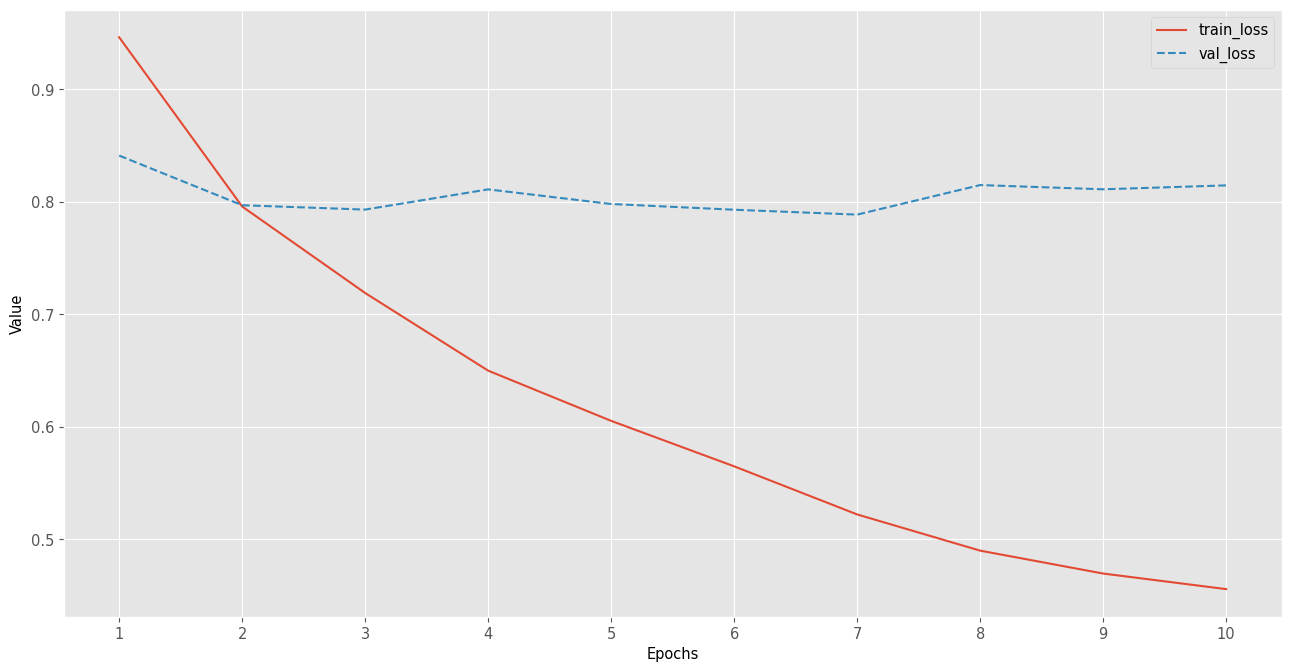

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


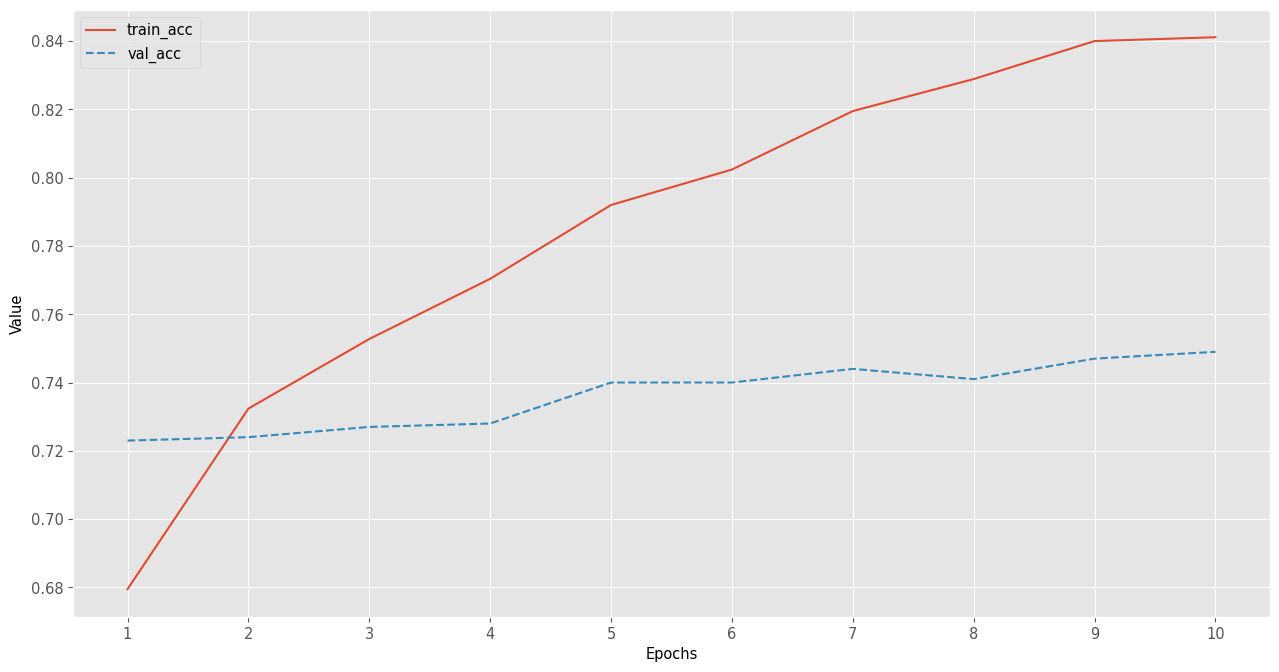

In [45]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, log_loss
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)
  train_precision = precision_score(train_labels, train_predict, average="macro")
  train_recall = recall_score(train_labels, train_predict, average="macro")
  train_f1 = f1_score(train_labels, train_predict, average="macro")

  # Get prediction form model on validation data.
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)
  val_precision = precision_score(valid_labels, valid_predict, average="macro")
  val_recall = recall_score(valid_labels, valid_predict, average="macro")
  val_f1 = f1_score(valid_labels, valid_predict, average="macro")

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print(f"train precision: {train_precision}, recall:{train_recall}, f1_score:{train_f1}")
  print(f"val precision: {val_precision}, recall:{val_recall}, f1_score:{val_f1}")

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])


In [35]:
# torch.save(model.state_dict(), "topic_classification_gpt2_model.pth")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# model.load_state_dict(torch.load("topic_classification_gpt2_model.pth"))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>

In [59]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, log_loss
model.eval()
model.to('cpu')
# Create a function for sentiment analysis
def predict_topic(text):
  inputs = tokenizer(text, return_tensors="pt")
  with torch.no_grad():
    logits = model(**inputs).logits
  probabilities = torch.nn.functional.softmax(logits, dim=1)
  return probabilities
inputs = dataset_dict['test']['text']
labels = dataset_dict['test']['label']
y_pred_gpt = []
for i, text in enumerate(inputs):
  arr=[]
  probabilities = predict_topic(text)
  for j in range(8):
    arr.append(probabilities[0][j].item())
  y_pred_gpt.append(arr)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
print("Test Metrics")
y_pred = np.argmax(y_pred_gpt, axis=1)
y_test = labels
# Print f1, precision, and recall scores
# print(f'Test loss: {log_loss(y_test,  y_pred)}')
print(f'accuracy: {accuracy_score(y_test,  y_pred)}')
print(f'precision:{precision_score(y_test, y_pred , average="macro")}')
print(f'recall:{recall_score(y_test, y_pred , average="macro")}')
print(f'f1_score:{f1_score(y_test, y_pred , average="macro")}')

Test Metrics
accuracy: 0.657
precision:0.6858930607275953
recall:0.6388417496285297
f1_score:0.641811436063373


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
